In [1]:
import warnings
warnings.filterwarnings("ignore")

import os, tqdm, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mlguess.classifier_uq import brier_multi, uq_results, sort_arr, brier_skill_score_multiclass
from mlguess.regression_uq import plot_skill_score
from mlguess.pit import pit_deviation_skill_score
from matplotlib.colors import LogNorm
from sklearn.metrics import brier_score_loss

In [2]:
#df = pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/evidential/evaluate/test_7.parquet")
df = pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/production/evidential/evaluate/test_7.parquet")

In [3]:
true_labels = df["true_label"].values
pred_labels = df["pred_label"]
pred_probs = df[[f"pred_conf{k+1}" for k in range(4)]].values
confidences = df["pred_conf"]

evidential = df["evidential"]
total = np.sqrt(df["epistemic"] + df["aleatoric"])
epistemic = np.sqrt(df["epistemic"])
aleatoric = np.sqrt(df["aleatoric"])

ale_sum = df[[f"aleatoric{k+1}" for k in range(4)]].sum(axis=1)
epi_sum = df[[f"epistemic{k+1}" for k in range(4)]].sum(axis=1)

df["ale_sum"] = ale_sum
df["epi_sum"] = epi_sum

df["total"] = total
df["total_sum"] = df["epi_sum"] + df["ale_sum"]

In [4]:
df_det = pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/production/classifier/evaluate/test_7.parquet")

In [5]:
n_splits = 10

ensemble_p = np.zeros((n_splits, df_det.shape[0]))
ensemble_std = np.zeros((n_splits, df_det.shape[0]))
ensemble_entropy = np.zeros((n_splits, df_det.shape[0]))
ensemble_mutual = np.zeros((n_splits, df_det.shape[0]))
ensemble_ale = np.zeros((n_splits, df_det.shape[0]))
ensemble_epi = np.zeros((n_splits, df_det.shape[0]))

# Loop over ensemble of parametric models
for split in tqdm.tqdm(range(n_splits)):
    dfe = pd.read_parquet(os.path.join("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/production/classifier", "evaluate", f"test_{split}.parquet"))
    ensemble_p[split] = dfe["pred_conf"]
    ensemble_std[split] = dfe["pred_conf"] * (1 - dfe["pred_conf"])
    ensemble_entropy[split] = dfe["entropy"]
    ensemble_mutual[split] = dfe["mutual_info"]
    ensemble_ale[split] = dfe[[f"aleatoric{k+1}" for k in range(4)]].sum(axis=1)
    ensemble_epi[split] = dfe[[f"epistemic{k+1}" for k in range(4)]].sum(axis=1)
    
# Compute averages, uncertainties 
df_det["ave_conf"] = np.mean(ensemble_p, axis = 0)
df_det["ave_entropy"] = np.mean(ensemble_entropy, axis = 0)
df_det["ave_mutual_info"] = np.mean(ensemble_mutual, axis = 0)

df_det["epistemic"] = df_det["epistemic"] #np.var(ensemble_p, axis = 0)
df_det["aleatoric"] = df_det["aleatoric"] #np.mean(ensemble_std, axis = 0)
df_det["total"] = df_det["epistemic"] + df_det["aleatoric"]

# df_det["ale_sum"] = np.sqrt(np.mean(ensemble_ale, axis = 0))
# df_det["epi_sum"] = np.sqrt(np.mean(ensemble_epi, axis = 0))
ale_sum = df_det[[f"aleatoric{k+1}" for k in range(4)]].sum(axis=1)
epi_sum = df_det[[f"epistemic{k+1}" for k in range(4)]].sum(axis=1)

df_det["ale_sum"] = ale_sum
df_det["epi_sum"] = epi_sum
df_det["total_sum"] = ale_sum + epi_sum

100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


In [6]:
#df_det = pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier/evaluate/test_7.parquet")

In [9]:
# n_splits = 10

# ensemble_p = np.zeros((n_splits, df_det.shape[0]))
# ensemble_std = np.zeros((n_splits, df_det.shape[0]))
# ensemble_entropy = np.zeros((n_splits, df_det.shape[0]))
# ensemble_mutual = np.zeros((n_splits, df_det.shape[0]))
# ensemble_p_sum = np.zeros((n_splits, df_det.shape[0], 4))
# ensemble_std_sum = np.zeros((n_splits, 4, df_det.shape[0]))

# # Loop over ensemble of parametric models
# for split in tqdm.tqdm(range(n_splits)):
#     dfe = pd.read_parquet(os.path.join("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier", "evaluate", f"test_{split}.parquet"))
#     ensemble_p[split] = dfe["pred_conf"]
#     ensemble_std[split] = dfe["pred_conf"] * (1 - dfe["pred_conf"])
#     ensemble_entropy[split] = dfe["entropy"]
#     ensemble_mutual[split] = dfe["mutual_info"]
    
# # Compute averages, uncertainties 
# df_det["ave_conf"] = np.mean(ensemble_p, axis = 0)
# df_det["ave_entropy"] = np.mean(ensemble_entropy, axis = 0)
# df_det["ave_mutual_info"] = np.mean(ensemble_mutual, axis = 0)
# df_det["epistemic"] = np.var(ensemble_p, axis = 0)
# df_det["aleatoric"] = np.mean(ensemble_std, axis = 0)
# df_det["total"] = df_det["epistemic"] + df_det["aleatoric"]

# df_det["epistemic"] = np.sqrt(df_det["epistemic"])
# df_det["aleatoric"] = np.sqrt(df_det["aleatoric"])
# df_det["total"] = np.sqrt(df_det["total"])

In [8]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_uncertainties(
    dfs,
    input_cols,
    output_cols,
    num_bins=20,
    legend_cols=None,
    x_labels=None,
    y_labels=None,
    fontsize=10,
    save_location=None,
    top1=True
):

    width = 10
    height = 3.5
    fig, axs = plt.subplots(1, len(dfs), figsize=(width, height), sharey = "col")#, sharey = "col", sharex = "row")

    if legend_cols is None:
        legend_cols = output_cols
        
    for i, df in enumerate(dfs):

        not_nan = np.isfinite(df[input_cols + output_cols])
        df = df[not_nan].copy()

        # Loop over each element in output_cols and create a hexbin plot
        for z, (i_col, o_col) in enumerate(zip(input_cols, output_cols)):
            # Calculate the mean prediction for the current column
            x_array = np.sqrt(df[o_col].copy())
            y_array = np.sqrt(df[i_col].copy())
            
            # Create logarithmic bin edges
            x_bins = np.logspace(
                1e-4,
                1e1,
                num=num_bins + 1,
            )
            y_bins = np.logspace(
                1e-4, # np.log10(np.nanmin(y_array))
                1e1, # np.log10(np.nanmax(y_array))
                num=num_bins + 1,
            )

            # Create the 2D histogram plot
            my_range = [
                [np.nanpercentile(x_array, 0), np.nanpercentile(x_array, 100)],
                [np.nanpercentile(y_array, 0), np.nanpercentile(y_array, 100)],
            ]
            
            # Create the histograms
            hist1, xedges1, yedges1 = np.histogram2d(x_array, y_array, bins=num_bins)
            # Calculate vmin and vmax
            vmin = np.min(hist1)
            vmax = np.max(hist1)
            print(vmin, vmax)
            
            # Create the 2D histogram plot
            hb = axs[i].hist2d(
                x_array,
                y_array,
                bins=num_bins,
                cmap="viridis_r",
                norm=colors.LogNorm(vmax=153027.0),
            )

            # Set the axis labels
            # axs[i].set_title(legend_cols[i], fontsize=fontsize)
            axs[i].set_xlabel(x_labels[z], fontsize=fontsize)
            if i == 0:
                axs[i].set_ylabel(y_labels[z], fontsize=fontsize)
            axs[i].tick_params(axis="both", which="major", labelsize=fontsize)

            # Move the colorbar below the x-axis label
            cbar = axs[i].figure.colorbar(hb[-1], ax=axs[i], pad = 0.025)#, shrink=0.80)
            cbar.set_label("Count")

            # Set the tick labels to use scientific notation
            axs[i].ticklabel_format(style="sci", axis="both", scilimits=(-1, 1))

            # Add 1-1 line
            smaller = min(min(x_array), min(y_array))
            larger = max(max(x_array), max(y_array))
            axs[i].plot(
                np.linspace(smaller, larger, 10),
                np.linspace(smaller, larger, 10),
                ls="--",
                c="k",
            )
            
    axs[0].set_title("Ensemble MLP", fontsize = 10)
    axs[1].set_title("Evidential MLP", fontsize = 10)

    if top1:
        axs[0].set_xlim([0, 0.275])
        axs[0].set_ylim([0, 0.505])
        axs[1].set_xlim([0, 0.275])
        axs[1].set_ylim([0, 0.505])
        axs[0].text(-0.075, 1.1, "(a)", transform=axs[0].transAxes,
          fontsize=10, va='top', ha='right')

        axs[1].text(-0.05, 1.1, "(b)", transform=axs[1].transAxes,
          fontsize=10, va='top', ha='right')
    else:
        axs[0].set_xlim([0, 0.39])
        axs[0].set_ylim([0, 0.87])
        axs[1].set_xlim([0, 0.39])
        axs[1].set_ylim([0, 0.87])
    
        axs[0].text(-0.075, 1.1, "(c)", transform=axs[0].transAxes,
          fontsize=10, va='top', ha='right')

        axs[1].text(-0.05, 1.1, "(d)", transform=axs[1].transAxes,
          fontsize=10, va='top', ha='right')
    
    # make it pretty
    plt.tight_layout()

    if save_location:
        plt.savefig(
            os.path.join(save_location, "compare_uncertanties.pdf"),
            dpi=300,
            bbox_inches="tight",
        )
        
    else:
        return fig

0.0 151518.0
0.0 55348.0


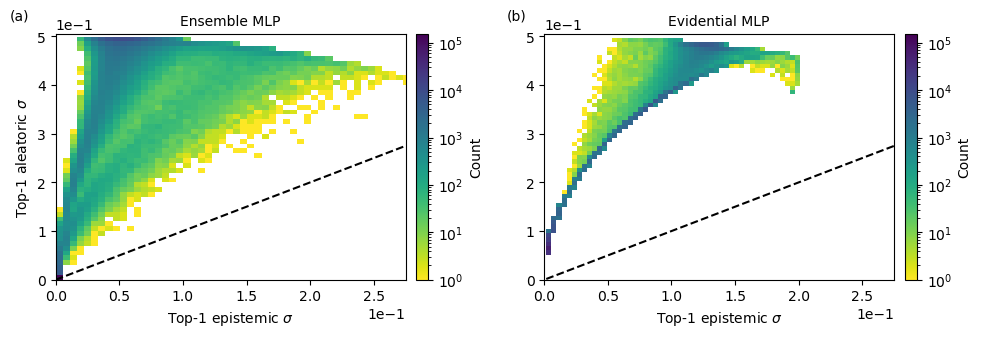

In [16]:
fig1 = plot_uncertainties(
    [df_det, df],
    ["aleatoric"],
    ["epistemic"],
    x_labels=[r"Top-1 epistemic $\sigma$"],
    y_labels=[r"Top-1 aleatoric $\sigma$"],
    num_bins=50,
    #save_location=save_location
)

0.0 153027.0
0.0 57838.0


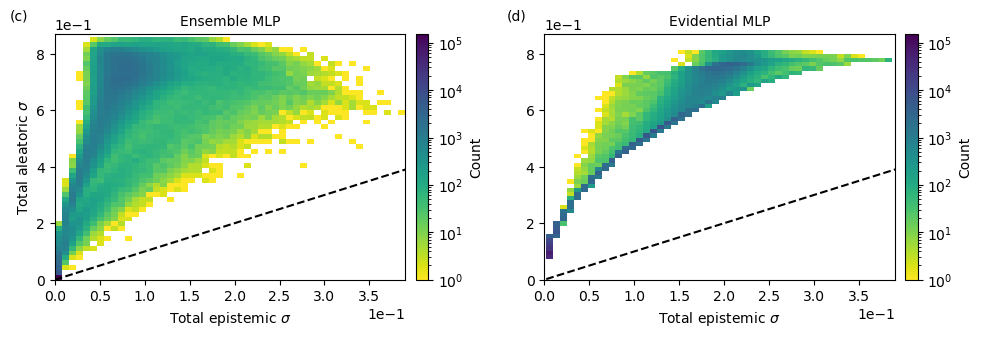

In [ ]:
fig1 = plot_uncertainties(
    [df_det, df],
    ["ale_sum"],
    ["epi_sum"],
    x_labels=[r"Total epistemic $\sigma$"],
    y_labels=[r"Total aleatoric $\sigma$"],
    num_bins=50,
    top1=False
    #save_location=save_location
)

### This next figure shows only the top-1 compared against u. In the calibrate notebook it is summed first

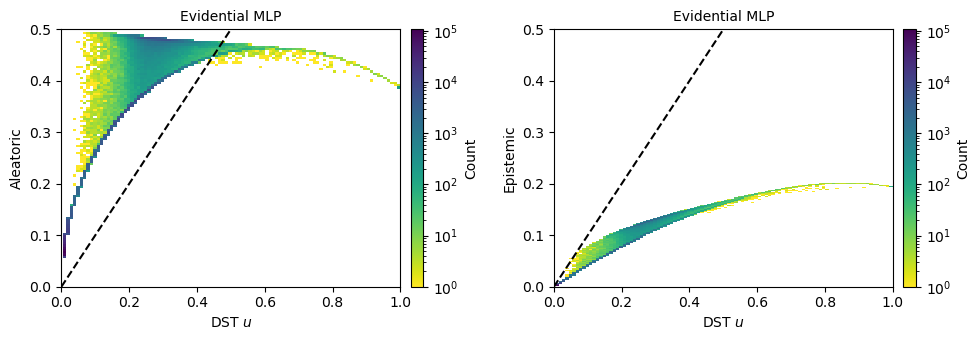

In [7]:
fig2, axs = plt.subplots(1, 2, figsize=(10, 3.5))
    
_ = axs[0].hist2d(evidential, aleatoric, bins = 100, norm = LogNorm(), cmap = "viridis_r")
hb = axs[1].hist2d(evidential, epistemic, bins = 100, norm = LogNorm(), cmap = "viridis_r")

axs[0].set_xlabel(r"DST $u$", fontsize = 10)
axs[1].set_xlabel(r"DST $u$", fontsize = 10)

axs[0].set_ylabel("Aleatoric", fontsize = 10)
axs[1].set_ylabel("Epistemic", fontsize = 10)

axs[0].set_title("Evidential MLP", fontsize = 10)
axs[1].set_title("Evidential MLP", fontsize = 10)

axs[0].plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1), 'k--')
axs[1].plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1), 'k--')

cbar = axs[0].figure.colorbar(hb[-1], ax=axs[0], pad = 0.025)#, shrink=0.80)
cbar.set_label("Count")
cbar = axs[1].figure.colorbar(hb[-1], ax=axs[1], pad = 0.025)#, shrink=0.80)
cbar.set_label("Count")

axs[0].set_xlim([0, 1.0])
axs[1].set_xlim([0, 1.0])
axs[0].set_ylim([0, 0.5])
axs[1].set_ylim([0, 0.5])

plt.tight_layout()

In [10]:
def brier_multi(targets, probs, num_classes=4, skill_score=True):
    # Create one-hots of the target to deal with multi-class problems
    one_hot = np.zeros((targets.size, num_classes))
    one_hot[np.arange(targets.size), targets] = 1
    # Compute MSE with one-hots and probabilities
    res = np.mean(np.mean((probs - one_hot) ** 2, axis=1))

    if skill_score:
        tot = np.mean(np.mean((one_hot - np.mean(one_hot)) ** 2, axis=1))
        return 1 - res / max(tot, 1.0e-7)
    else:
        return res
    
    
def cross_entropy(targets, probs, num_classes = 4):
    one_hot = np.zeros((targets.size, num_classes))
    one_hot[np.arange(targets.size), targets] = 1
    num_samples = probs.shape[0]
    epsilon = 1e-10  # Small value to avoid numerical instability
    cross_entropy_loss = -np.sum(one_hot * np.log(probs + epsilon)) / num_samples
    return cross_entropy_loss
    
# def brier_multi(targets, probs, num_classes=4, skill_score=True):
#     # Create one-hots of the target to deal with multi-class problems
#     one_hot = np.zeros((targets.size, num_classes))
#     one_hot[np.arange(targets.size), targets] = 1
#     # Compute MSE with one-hots and probabilities
#     res = np.mean((probs - one_hot) ** 2)

#     if skill_score:
#         tot = np.mean((one_hot - np.mean(one_hot)) ** 2)
#         return 1 - res / max(tot, 1.0e-7)
#     else:
#         return res

In [11]:
def sort_arr(true_labels, pred_probs, confidences, n_bins=10, data_min = None, data_max = None, geom = True):
    
    # Compute the minimum and maximum values
    if data_min is None:
        data_min = np.min(confidences)
    if data_max is None:
        data_max = np.max(confidences)

    # Compute the range and standard deviation
    data_range = data_max - data_min
    data_std = np.std(confidences)

    # Use np.geomspace if the range of values is large compared to the standard deviation
    if data_range > 10 * data_std and geom:
        if data_min  == 0.0:
            data_min = 1e-7
        bins = np.geomspace(data_min, data_max, n_bins + 1)

    # Use np.linspace if the range of values is small compared to the standard deviation
    else:
        bins = np.linspace(data_min, data_max, n_bins + 1)
        
    #bins = np.logspace(np.log(data_min), np.max(data_max), num=n_bins+1, endpoint=True)
        
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    pred_labels = np.argmax(pred_probs, axis=1)
    results = defaultdict(list)
    for i in range(n_bins):
        condition = np.logical_and(confidences >= bins[i], confidences < bins[i + 1])
        if condition.sum() > 0:
            bs = brier_multi(true_labels[condition], pred_probs[condition], skill_score = False)
            ce = cross_entropy(true_labels[condition], pred_probs[condition])
            #bs = np.sqrt(brier_skill_score_multiclass(true_labels[condition], pred_probs[condition], skill_score = False))
            #if bs > 0.5:
            #    print(bs, true_labels[condition][0], pred_probs[condition][0])
            results["bss"].append(bs)
            results["eb"].append(1.0 / np.sqrt(condition.sum()))
            results["acc"].append(
                (true_labels[condition] == pred_labels[condition]).mean()
            )
            results["count"].append(condition.sum())
            results["bin"].append(bin_centers[i])
            results["conf"].append(np.mean(confidences[condition]))
            results["ce"].append(ce)
            
            
        else:
            results["count"].append(0)
            results["bin"].append(bin_centers[i])
            results["acc"].append(0.0)
            results["eb"].append(0.0)
            results["bss"].append(0.0)
            results["conf"].append(0.0)

    return results["bin"], results


def classifier_attribution(
    true_labels,
    pred_probs,
    num_bins=10,
    legend_cols=["Rain", "Snow", "Sleet", "Frz Rain"],
):
    
    fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey="row", sharex="col")
    confidences = np.max(pred_probs, axis=1)

    for true_label in sorted(set(list(true_labels))):

        c = true_labels == true_label
        bin_centers, results = sort_arr(
            true_labels[c], pred_probs[c], confidences[c], n_bins = num_bins,
            data_min = 0, data_max = 1, geom = False
        )
        
        normalized_counts = (results["count"] - np.min(results["count"])) / (np.max(results["count"]) - np.min(results["count"]))
        colormap = matplotlib.colormaps.get_cmap('Reds')
        # axs[1][true_label].errorbar(
        #     bin_centers, results["acc"], yerr=results["eb"]
        # )
        sc = axs[true_label].scatter(
            bin_centers, results["acc"], c=normalized_counts, 
            cmap = colormap, zorder = 5, marker='s', s = 100, edgecolor = "k"
        )
        sc.set_clip_on(False)
        #cbar = plt.colorbar(sc, orientation='horizontal', location='top')
        #cbar.set_label('Normalized count')

        bin_centers = np.linspace(0, 1, 10)
        ave_true = np.mean(true_labels == true_label)
        ave_true_range = np.array([ave_true for x in bin_centers])

        no_skill = [0.5 * x1 + 0.5 * ave_true for x1 in bin_centers]
        axs[true_label].plot(bin_centers, no_skill, "b-")
        axs[true_label].plot(
            np.linspace(0, 1, len(ave_true_range)), ave_true_range, ls=":", color="k"
        )
        axs[true_label].plot(
            ave_true_range, np.linspace(0, 1, len(ave_true_range)), ls=":", color="k"
        )
        axs[true_label].plot(bin_centers, bin_centers, ls=":", color="k")

        fill_cond = np.where(bin_centers < ave_true)[0]
        axs[true_label].fill_between(
            np.array(bin_centers)[fill_cond],
            0,
            np.array(no_skill)[fill_cond],
            color="lightblue",
        )
        fill_cond = np.where(bin_centers >= ave_true)[0]
        axs[true_label].fill_between(
            np.array(bin_centers)[fill_cond],
            1,
            np.array(no_skill)[fill_cond],
            color="lightblue",
        )
        
        axs[true_label].set_xlim([0, 1.01])
        axs[true_label].set_ylim([0, 1.01])
        axs[true_label].set_title(legend_cols[true_label], fontsize = 10)
        axs[true_label].set_xlabel("Predicted Probability")

    axs[0].set_ylabel("Conditional Observed\n Probability")
    
    # Create a single colorbar
    cbaxes = fig.add_axes([0.125, -0.01, 0.8, 0.035])  # left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbaxes, orientation="horizontal", pad = 0.2)
    cbar.set_label("Normalized count")

    plt.tight_layout()
    
    
def classifier_attribution_compare(
    true_labels_lst,
    pred_probs_lst,
    num_bins=10,
    legend_cols=["Rain", "Snow", "Sleet", "Frz Rain"],
):
    
    fig, axs = plt.subplots(len(true_labels_lst), 4, figsize=(10, 5), sharey="row", sharex="col")
    
    for k, (true_label, pred_probs) in enumerate(zip(true_labels_lst, pred_probs_lst)):
    
        confidences = np.max(pred_probs, axis=1)
        
        for true_label in sorted(set(list(true_labels))):

            c = true_labels == true_label
            bin_centers, results = sort_arr(
                true_labels[c], pred_probs[c], confidences[c], n_bins = num_bins,
                data_min = 0, data_max = 1, geom = False
            )

            normalized_counts = (results["count"] - np.min(results["count"])) / (np.max(results["count"]) - np.min(results["count"]))
            colormap = matplotlib.colormaps.get_cmap('Reds')
            # axs[1][true_label].errorbar(
            #     bin_centers, results["acc"], yerr=results["eb"]
            # )
            sc = axs[k][true_label].scatter(
                bin_centers, results["acc"], c=normalized_counts, 
                cmap = colormap, zorder = 5, marker='s', s = 100, edgecolor = "k"
            )
            sc.set_clip_on(False)
            #cbar = plt.colorbar(sc, orientation='horizontal', location='top')
            #cbar.set_label('Normalized count')

            bin_centers = np.linspace(0, 1, 100)
            ave_true = np.mean(true_labels == true_label)
            ave_true_range = np.array([ave_true for x in bin_centers])

            no_skill = [0.5 * x1 + 0.5 * ave_true for x1 in bin_centers]
            axs[k][true_label].plot(bin_centers, no_skill, "b-")
            axs[k][true_label].plot(
                np.linspace(0, 1, len(ave_true_range)), ave_true_range, ls=":", color="k"
            )
            axs[k][true_label].plot(
                ave_true_range, np.linspace(0, 1, len(ave_true_range)), ls=":", color="k"
            )
            axs[k][true_label].plot(bin_centers, bin_centers, ls=":", color="k")

            fill_cond = np.where(bin_centers < ave_true)[0]
            axs[k][true_label].fill_between(
                np.array(bin_centers)[fill_cond],
                0,
                np.array(no_skill)[fill_cond],
                color="lightblue",
            )
            fill_cond = np.where(bin_centers >= ave_true)[0]
            axs[k][true_label].fill_between(
                np.array(bin_centers)[fill_cond],
                1.0,
                np.array(no_skill)[fill_cond],
                color="lightblue",
            )

            axs[k][true_label].set_xlim([0, 1.01])
            axs[k][true_label].set_ylim([0, 1.01])
            axs[0][true_label].set_title(legend_cols[true_label], fontsize = 10)
            
            if k == 1:
                axs[k][true_label].set_xlabel("Predicted Probability")

    axs[0][0].set_ylabel("Conditional Observed\n Probability (Deterministic)")
    axs[1][0].set_ylabel("Conditional Observed\n Probability (Evidential)")
    
    axs[0][0].text(-0.25, 1.1, "(a)", transform=axs[0][0].transAxes,
      fontsize=12, va='top', ha='right')
    
    axs[1][0].text(-0.25, 1.05, "(b)", transform=axs[1][0].transAxes,
      fontsize=12, va='top', ha='right')
    
    # Create a single colorbar
    cbaxes = fig.add_axes([0.125, -0.02, 0.8, 0.03])  # left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbaxes, orientation="horizontal", pad = 0.2)
    cbar.set_label("Normalized count")

    plt.tight_layout()
    
    # plt.savefig(
    #     os.path.join(save_location, "pit_histogram_ensemble.png"),
    #     dpi=300,
    #     bbox_inches="tight",
    # )


In [12]:
for k in range(4):
    c = true_labels == k
    print(
        brier_multi(true_labels[c], pred_probs[c], skill_score = False),
        brier_multi(true_labels[c], pred_probs[c], skill_score = True)
    )

0.03230346316527785 0.8277148631185182
0.08004133459707674 0.573112882148924
0.12187114920008962 0.350020537599522
0.09980300287614635 0.46771731799388616


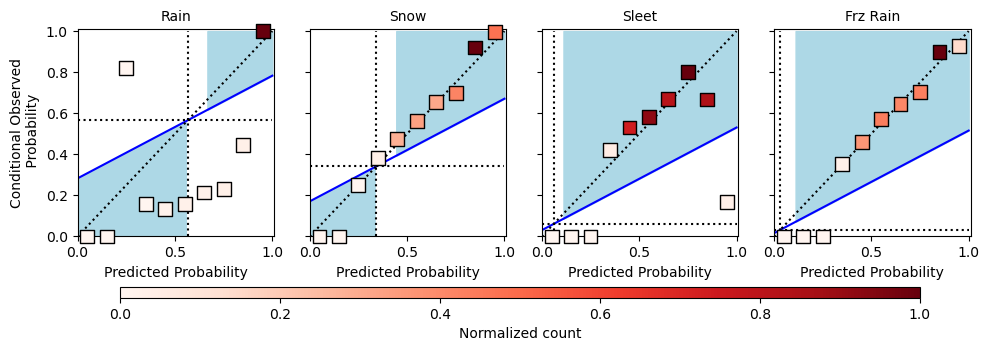

In [13]:
classifier_attribution(
    true_labels,
    pred_probs
)

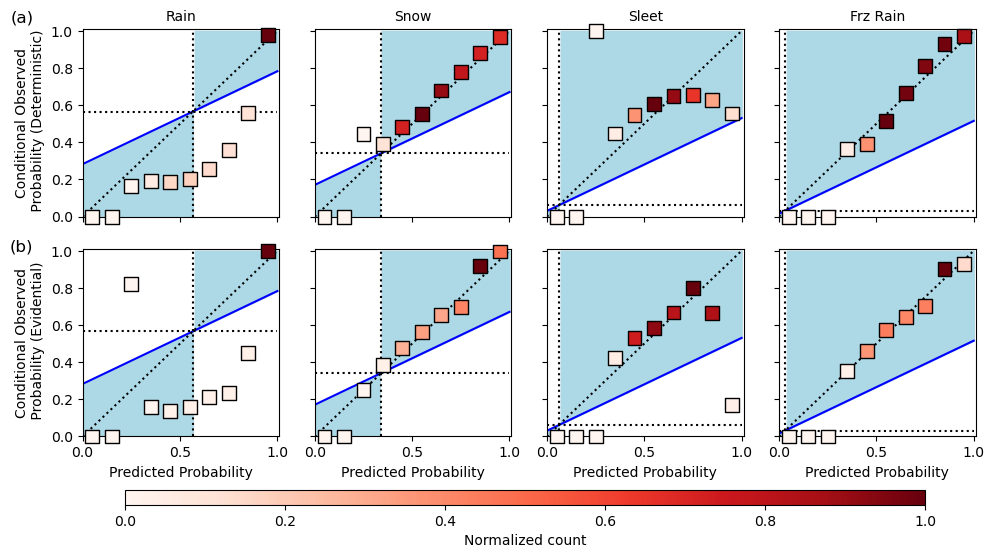

In [14]:
classifier_attribution_compare(
    [df_det["true_label"], df["true_label"]],
    [df_det[[f"pred_conf{k+1}" for k in range(4)]].values, df[[f"pred_conf{k+1}" for k in range(4)]].values]
)

### Skill-Score plot

In [35]:
def classifier_skill_scores(
    true_labels_list,
    pred_probs_list,
    aleatoric_list,
    epistemic_list,
    total_list,
    evidential_list,
    num_bins=10,
    legend_cols=[r"Aleatoric $\sigma$", "Epistemic $\sigma$", "Total $\sigma$", "Evidential"],
    save_location=False,
    prefix=False,
):

    fig, axs = plt.subplots(len(total_list), 4, figsize=(10, 4.5), sharey="row", sharex = "col")
    
    if len(total_list) == 1:
        axs = [axs]
    
    iters = zip(
        true_labels_list,
        pred_probs_list,
        aleatoric_list,
        epistemic_list,
        total_list,
        evidential_list
    )
    
    for j, (true_labels, pred_probs, aleatoric, epistemic, total, evidential) in enumerate(iters):

        for k, uq in enumerate([aleatoric, epistemic, total, evidential]):
            bin_centers, results = sort_arr(
                true_labels, pred_probs, uq, num_bins * num_bins
            )
            norm = LogNorm(vmin=min(results["count"])+1, vmax=153027.0)
            rescaled_bin_centers = (bin_centers - np.min(bin_centers)) / np.ptp(bin_centers)
            
            #normalized_counts = results["count"] / max(results["count"]) #(results["count"] - np.min(results["count"])) / (np.max(results["count"]) - np.min(results["count"]))
            #print(len(results["conf"]), len(results["bss"]), len(results["count"]))            
            _, _, _, sc = axs[j][k].hist2d(
                results["conf"], #rescaled_bin_centers,
                [np.sqrt(x) for x in results["bss"]],
                weights=results["count"],
                bins=(num_bins, num_bins),
                range=((0, 1), (0, 1)),
                cmap="viridis_r",
                norm=norm
            )


            axs[j][k].plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), "r:", lw=3)
            #axs[k].set_title(legend_cols[k], fontsize=10)
            
            if j == 0 and legend_cols[k] == "Evidential":
                axs[j][k].set_xlabel("Entropy, $H$", fontsize = 10)
            elif j == 1 and legend_cols[k] == "Evidential":
                axs[j][k].set_xlabel("DST $u$", fontsize = 10)
            elif j == 1:
                axs[j][k].set_xlabel(f'{legend_cols[k]}' + r' $\sigma$', fontsize=10)
            # axs[k].set_xscale("log")

            #ax2 = axs[k].twiny()
            #ax2.set_xlim(0, max(uq))
            # ax2.set_xticklabels = bin_centers

            if j == 0 and k == 0:
                axs[j][k].set_ylabel("Brier Score\n(Ensemble MLP)", fontsize=10)
            elif j == 1 and k == 0:
                axs[j][k].set_ylabel("Brier Score\n(Evidential MLP)", fontsize=10)
                
                
            axs[j][k].set_ylim([0.0, 0.65])
            
            
    axs[0][0].text(-0.25, 1., "(a)", transform=axs[0][0].transAxes,
      fontsize=10, va='top', ha='right')
    
    axs[1][0].text(-0.25, 1., "(b)", transform=axs[1][0].transAxes,
      fontsize=10, va='top', ha='right')
            
            
    print(sc)
    #Create a single colorbar
    cbaxes = fig.add_axes([0.125, -0.02, 0.8, 0.03])  # left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbaxes, orientation="horizontal", pad = 0.2, norm = norm)
    cbar.set_label("Count")

    plt.tight_layout()
    if save_location:
        if prefix:
            name = f"class_skill_{prefix}.pdf"
        else:
            name = "class_skill.pdf"
        plt.savefig(
            os.path.join(save_location, name),
            dpi=300,
            bbox_inches="tight",
        )

In [26]:
true_labels = df["true_label"].values
pred_labels = df["pred_label"]
pred_probs = df[[f"pred_conf{k+1}" for k in range(4)]].values
confidences = df["pred_conf"]

evidential = df["evidential"]
total = np.sqrt(df["epistemic"] + df["aleatoric"])
epistemic = np.sqrt(df["epistemic"])
aleatoric = np.sqrt(df["aleatoric"])

true_labels_det = df_det["true_label"].values
pred_labels_det = df_det["pred_label"]
pred_probs_det = df_det[[f"pred_conf{k+1}" for k in range(4)]].values
confidences_det = df_det["pred_conf"]

evidential_det = df_det["entropy"]
total_det = np.sqrt(df_det["epistemic"] + df["aleatoric"])
epistemic_det = np.sqrt(df_det["epistemic"])
aleatoric_det = np.sqrt(df_det["aleatoric"])

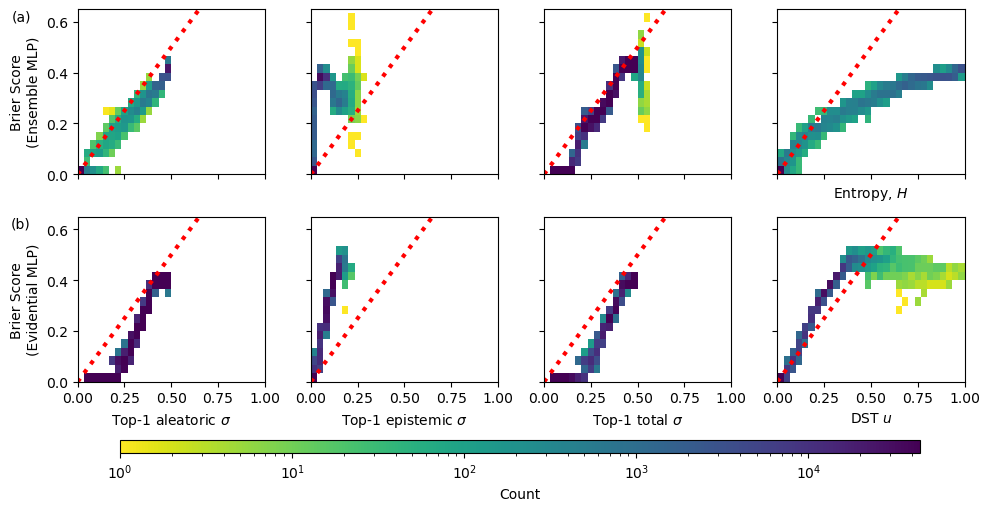

In [32]:
classifier_skill_scores(
    [true_labels_det, true_labels],
    [pred_probs_det, pred_probs],
    [aleatoric_det, aleatoric],
    [epistemic_det, epistemic],
    [total_det, total],
    [evidential_det, evidential],
    num_bins=30,
    legend_cols=["Top-1 aleatoric", "Top-1 epistemic", "Top-1 total", "Evidential"],
    save_location=False
) 

In [33]:
true_labels = df["true_label"].values
pred_labels = df["pred_label"]
pred_probs = df[[f"pred_conf{k+1}" for k in range(4)]].values
confidences = df["pred_conf"]

evidential = df["evidential"]
total = np.sqrt(df["total_sum"])
epistemic = np.sqrt(df["epi_sum"])
aleatoric = np.sqrt(df["ale_sum"])

true_labels_det = df_det["true_label"].values
pred_labels_det = df_det["pred_label"]
pred_probs_det = df_det[[f"pred_conf{k+1}" for k in range(4)]].values
confidences_det = df_det["pred_conf"]

evidential_det = df_det["entropy"]
total_det = np.sqrt(df_det["total_sum"])
epistemic_det = np.sqrt(df_det["epi_sum"])
aleatoric_det = np.sqrt(df_det["ale_sum"])

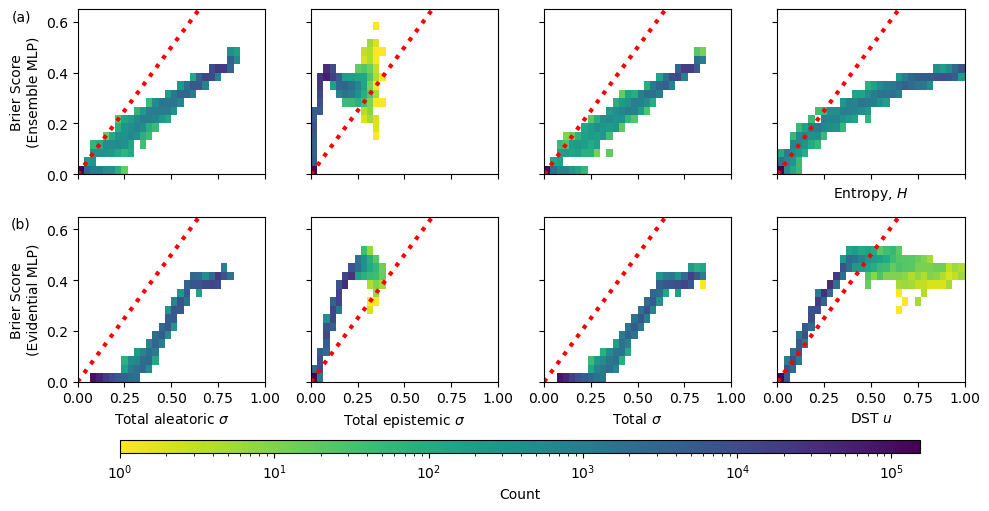

In [36]:
classifier_skill_scores(
    [true_labels_det, true_labels],
    [pred_probs_det, pred_probs],
    [aleatoric_det, aleatoric],
    [epistemic_det, epistemic],
    [total_det, total],
    [evidential_det, evidential],
    num_bins=30,
    legend_cols=["Total aleatoric", "Total epistemic", "Total", "Evidential"],
    save_location=False
) 

In [ ]:
def random_sample_true_labels_and_pred_probs(num_samples):
    """
    Randomly samples true_labels and pred_probs for a given number of samples.

    Parameters:
        num_samples (int): The number of samples to generate.

    Returns:
        true_labels (numpy array): A 1D array of shape (num_samples,) containing zeros with a single one entry randomly placed.
        pred_probs (numpy array): A 2D array of shape (num_samples, 4) containing random probability distributions for each sample,
                                 where each distribution has four values that sum to 1 and are greater than zero.
    """
    # Randomly generate true_labels with one entry as one and the rest as zeros
    true_labels = np.zeros((num_samples,), dtype=int)
    random_index = np.random.randint(0, num_samples)
    true_labels[random_index] = 1

    # Randomly generate pred_probs with values summing to 1 and greater than zero for each sample
    pred_probs = np.random.rand(num_samples, 4)
    #pred_probs /= pred_probs.sum(axis=1, keepdims=True)
    bs = brier_multi(true_labels, pred_probs, skill_score = False)
    
    return bs

In [ ]:
bs = brier_multi(true_labels, pred_probs, skill_score = False)

In [ ]:
# for entropy, perhaps compare against cross entropy loss
# perhaps invert logistic u --> maybe linear

In [67]:
# # df = pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/calibration/20/evaluate/test.parquet")

# # true_labels = df["true_label"].values
# # pred_labels = df["pred_label"]
# # pred_probs = df[[f"pred_conf{k+1}" for k in range(4)]].values
# # confidences = df["pred_conf"]

# # evidential = df["evidential"]
# # total = np.sqrt(df["epistemic"] + df["aleatoric"])
# # epistemic = np.sqrt(df["epistemic"])
# # aleatoric = np.sqrt(df["aleatoric"])

# classifier_skill_scores(
#     [true_labels_det, true_labels],
#     [pred_probs_det, pred_probs],
#     [aleatoric_det, aleatoric],
#     [epistemic_det, epistemic],
#     [total_det, total],
#     [evidential_det, evidential],
#     num_bins=20,
#     legend_cols=["Aleatoric", "Epistemic", "Total", "Evidential"],
#     save_location=False
# ) 

### Confusion matrices

In [9]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
    data_list, classes, font_size=10, normalize=False, axis=1, cmap=plt.cm.Blues, save_location=None
):
    """
    Function to plot a confusion matrix.
    """
    
    fig, axs = plt.subplots(
        nrows=2, ncols=len(data_list[0]), figsize=(10, 6), sharex="col", sharey="row"
    )
    
    
    for k, data in enumerate(data_list):

        for i, (key, ds) in enumerate(data.items()):
            ax = axs[k][i]
            cm = confusion_matrix(ds["true_label"], ds["pred_label"]).astype(np.float32)
            cm /= float(cm.sum())
        
            im = ax.imshow(cm, interpolation="nearest", cmap=cmap, norm = "log", vmin=1.6142592e-05, vmax=1.0)
            if i == 1:
                cbar = ax.figure.colorbar(im, ax=ax, pad = 0.025)#, shrink=0.80)
                cbar.set_label("Normalized count")
            ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]))
            ax.set_xticklabels(classes, fontsize=font_size)
            ax.set_yticklabels(classes, fontsize=font_size)
            if i == 0:
                ax.set_ylabel("True label", fontsize=font_size)
            if k == 0:
                ax.set_title(key, fontsize=font_size)
            if k == 1:
                ax.set_xlabel("Predicted label", fontsize=font_size)

            fmt = ".2f" if normalize else "d"
            thresh = 0.15 #cm.max() / 2.0

            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(
                        j,
                        i,
                        "{:.2f}".format(cm[i, j]), #format(cm[i, j], fmt),
                        ha="center",
                        va="center",
                        color="white" if cm[i, j] > thresh else "black",
                        fontsize=font_size,
                    )

            # Minor ticks
            ax.set_xticks(np.arange(-.5, 4.5, 1), minor=True)
            ax.set_yticks(np.arange(-.5, 4.5, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

            # Remove minor ticks
            ax.tick_params(which='minor', bottom=False, left=False)
            
    plt.subplots_adjust(wspace=-1.15, hspace=0)
    
    axs[0][0].text(0.135, 1.175, "(a) Deterministic", transform=axs[0][0].transAxes,
      fontsize=10, va='top', ha='right')
    
    axs[1][0].text(0.025, 1.115, "(b) Evidential", transform=axs[1][0].transAxes,
      fontsize=10, va='top', ha='right')
                
    plt.tight_layout()
    if save_location:
        plt.savefig(save_location, dpi=300, bbox_inches="tight")

In [10]:
data = { 
    "Train": pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/production/evidential/evaluate/train_7.parquet"),
    "Test": pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/production/evidential/evaluate/test_7.parquet")
}

In [11]:
data_det = {
    "Train": pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/production/classifier/evaluate/train_7.parquet"),
    "Test": pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/production/classifier/evaluate/test_7.parquet")
}

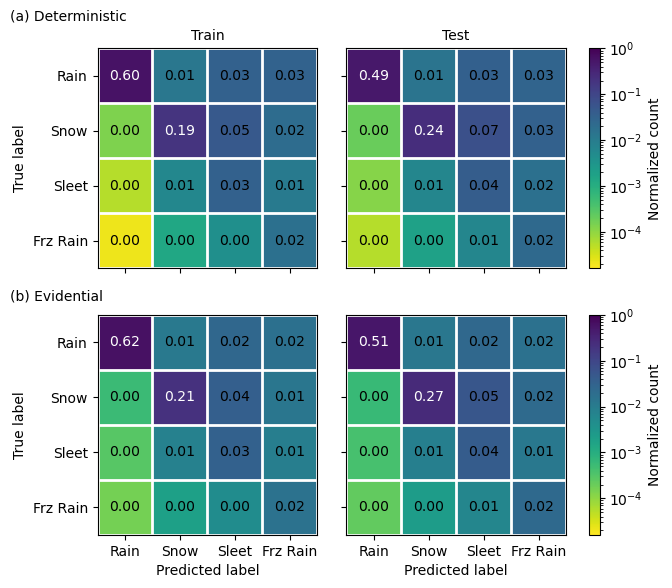

In [12]:
plot_confusion_matrix(
        [data_det, data],
        ["Rain", "Snow", "Sleet", "Frz Rain"],
        cmap = "viridis_r"
        #save_location=os.path.join(save_loc, "plots", "confusion_matrices_axis1.pdf"),
    )

### Drop fraction

In [14]:
def brier_multi(targets, probs, num_classes=4, skill_score=True):
    # Create one-hots of the target to deal with multi-class problems
    one_hot = np.zeros((targets.size, num_classes))
    one_hot[np.arange(targets.size), targets] = 1
    # Compute MSE with one-hots and probabilities
    #res = np.mean(np.sum((probs - one_hot) ** 2, axis=1))
    res = np.mean((probs-one_hot)**2)

    if skill_score:
        #tot = np.mean(np.sum((one_hot - np.mean(one_hot)) ** 2, axis=1))
        tot = np.mean((one_hot - np.mean(one_hot))**2)
        return 1 - res / max(tot, 1.0e-7)
    else:
        return res

In [24]:
def classifier_discard_fraction(
    dfs,
    num_bins=10,
    num_classes=4,
    uncertainty_cols_lst=["aleatoric", "epistemic", "total", "evidential"],
    legend_cols=["Rain", "Snow", "Sleet", "Frz Rain"],
    plt_titles_lst=["Aleatoric", "Epistemic", "Total", "Evidential"],
    colors=["m", "b", "y", "c"], #["#f8d605", "#ce4912", "#042c71", "b", "g"],
    save_location=False,
    prefix=False,
):
    
    
    # color_dict = {0: 'm',
    #           1: 'b',
    #           2: 'y',
    #           3: 'c'}

    fig, axs = plt.subplots(1, 4, figsize=(10, 4), sharey="row")
    db = (1.0 / num_classes) * num_bins
    # df["total"] = np.sqrt(df["aleatoric"] + df["epistemic"])

    results = defaultdict(list)
    markers = ["o", "s", "p", "^"]
    
    for j, df in enumerate(dfs):
        
        uncertainty_cols = uncertainty_cols_lst[j]
        plt_titles = plt_titles_lst[j]
    
        for k, uq in tqdm.tqdm(enumerate(uncertainty_cols), total = len(uncertainty_cols)):
            
            dg = df.sort_values(uq)

            for class_label in range(num_classes):
                dr = dg[dg["true_label"] == class_label]#.copy()
                results = defaultdict(list)
                percentage = np.linspace(0, 1, dr.shape[0])
                for percent in np.linspace(5, 100, num_bins):
                    c = percentage < percent / 100.0
                    if c.sum() == 0:
                        continue
                    acc = (dr[c]["true_label"] == dr[c]["pred_label"]).mean()
                    # bss = dr[c]["bss"].mean()
                    # bss = brier_multi(
                    #     dr[c]["true_label"].values,
                    #     dr[c][[f"pred_conf{k+1}" for k in range(num_classes)]].values,
                    # )
                    bss = brier_multi(
                            dr[c]["true_label"].values, 
                            dr[c][[f"pred_conf{k+1}" for k in range(num_classes)]].values, 
                            skill_score = True)
                    
                    results["acc"].append(acc)
                    results["bss"].append(bss)
                    results["frac"].append(percent)

                ls = "-" if j == 0 else ":"
                marker = markers[class_label]
                
                axs[k].plot(
                    [100 - x for x in results["frac"]],
                    results["bss"],
                    color=colors[class_label],
                    ls = ls, 
                    lw = 2,
                    marker=marker,
                    markersize=4,
                    markevery=5
                )

            if j == 0:
                axs[k].set_xlabel("Fraction removed", fontsize = 10)
                axs[k].set_title(plt_titles[k], fontsize = 10)
                axs[k].legend(legend_cols, loc="best", fontsize = 10)
                
                # Create a custom legend with symbols only
                legend_handles = []
                for class_label, legend_col in zip(range(num_classes), legend_cols):
                    marker = markers[class_label]
                    legend_handles.append(
                        plt.Line2D(
                            [],
                            [],
                            marker=marker,
                            color="w",
                            markerfacecolor=colors[class_label],
                            markersize=8,
                            label=legend_col,
                        )
                    )
                axs[k].legend(handles=legend_handles, loc="best", fontsize = 10)
                axs[0].set_ylabel("Brier Skill Score", fontsize = 10)
     
    for ax in axs:
        xarr = [100 - x for x in results["frac"]]
        ax.plot(xarr, [0 for xx in xarr], c = "k", ls = ":")

    plt.tight_layout()

    if save_location:
        if prefix:
            name = f"discard_fraction_{prefix}.pdf"
        else:
            name = "discard_fraction.pdf"
        plt.savefig(
            os.path.join(save_location, name),
            dpi=300,
            bbox_inches="tight",
        )

In [16]:
def get_names(df):
    if "ave_entropy" in df:
        evidential = df["ave_entropy"] 
        df_cols = ["aleatoric", "epistemic", "total", "ave_entropy"]
        uq_names = ["Aleatoric", "Epistemic", "Total", r"Entropy/DST $u$"]
    else:
        evidential = df["evidential"]
        df_cols = ["aleatoric", "epistemic", "total", "evidential"]
        uq_names = ["Aleatoric", "Epistemic", "Total", r"Entropy/DST $u$"]
    return df_cols, uq_names

100%|██████████| 4/4 [01:23<00:00, 20.93s/it]


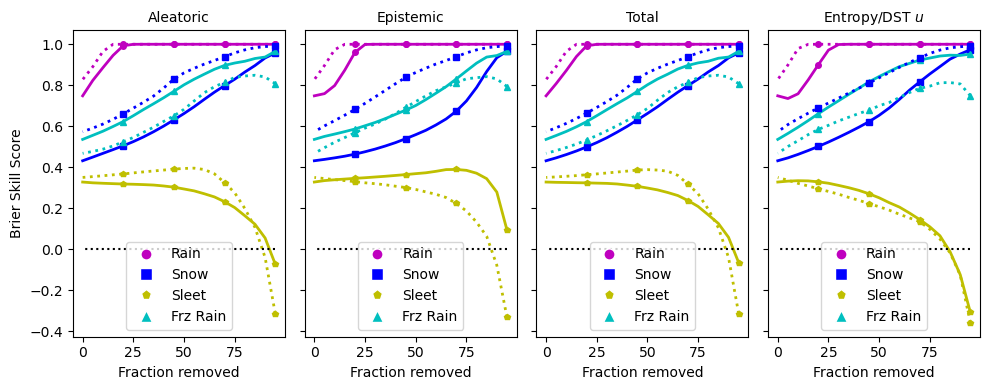

In [27]:
df_cols_det, uq_names_det = get_names(df_det)
df_cols, uq_names = get_names(df)

save_location = "/glade/work/schreck/repos/miles-guess/evidential_paper_results"

classifier_discard_fraction(
    [df_det, df],
    save_location=save_location,
    plt_titles_lst=[uq_names_det, uq_names],
    uncertainty_cols_lst=[df_cols_det, df_cols],
    prefix=None, 
    num_bins = 20
)

In [22]:
for class_label in range(4):
    dr = df[df["true_label"] == class_label]#.copy()
    bss = brier_multi(
            dr["true_label"].values, 
            dr[[f"pred_conf{k+1}" for k in range(4)]].values, 
            skill_score = True)
    print(class_label, bss)

0 0.8277148631185182
1 0.5731128821489238
2 0.3500205375995219
3 0.46771731799388616


In [23]:
for class_label in range(4):
    dr = df_det[df_det["true_label"] == class_label]#.copy()
    bss = brier_multi(
            dr["true_label"].values, 
            dr[[f"pred_conf{k+1}" for k in range(4)]].values, 
            skill_score = True)
    print(class_label, bss)

0 0.7483410341633188
1 0.4314692978327096
2 0.3275686163887904
3 0.5356434564759296
